# 训练营——机器学习L1系列
## 机器学习
## 贷款审批结果预测

这个项目中，我们将处理以csv文件格式存储的数据。数据来自竞赛https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/ 

银行的放贷审批，核心要素为风险控制。因此，对于申请人的审查关注的要点为违约可能性。而违约可能性通常由申请人收入情况、稳定性、贷款数额及偿还年限等因素来衡量。该项目根据申请人条件，进一步细化得到各个变量对于违约评估的影响，从而预测银行是否会批准贷款申请。在项目实现过程中使用了经典的机器学习算法，对申请贷款客户进行科学归类，从而帮助金融机构提高对贷款信用风险的控制能力。

> **提示**：这样的文字将会指导你如何使用 jupyter Notebook 来完成项目。你可以通过单击代码区域，然后使用键盘快捷键 Shift+Enter 或 Shift+Return 来运行代码。或者在选择代码后使用执行（run cell）按钮执行代码。Markdown的文字区域也同样可以如此操作。

> 在如下有**# TODO** 提示的地方，将代码补全，实现注释中所要求的功能。


## 1. 数据读取

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
file = './data/loan_records.csv'
loan_df = pd.read_csv(file)

### 1.1 数据预览

In [2]:
print('数据集一共有{}行，{}列'.format(loan_df.shape[0], loan_df.shape[1]))

数据集一共有614行，13列


In [3]:
loan_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


从贷款数据样本中，可以观察得到数据的特征

- **Loan_ID**：样本标号
- **Gender**：贷款人性别 (Male/ Female)
- **Married**：是否结婚 (Y/N)
- **Dependents**：供养人数
- **Education**: 受教育程度 (Graduate/ Not Graduate)
- **Self_Employed**：是否自雇 (Y/N)
- **ApplicantIncome**：申请人收入
- **CoapplicantIncome**：联合申请人收入
- **LoanAmount**：贷款金额（单位：千）
- **Loan_Amount_Term**：贷款期限（单位：月）
- **Credit_History**：历史信用是否达标（0/1）
- **Property_Area**：居住地区（Urban/ Semi Urban/ Rural）
- **Loan_Status**：是否批准（Y/N）
---
在我们即将构建的机器学习模型当中，**Loan_Status**将是模型训练的目标列

### 1.2 数据统计信息

In [4]:
loan_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


观察数据情况可以得知：

- LoanAmount、Loan_Amount_Term、Credit_History有明显的缺失值(count值比较小)，需要进行空值处理

## 2. 数据处理

### 2.1 重复值处理

In [5]:
if loan_df[loan_df['Loan_ID'].duplicated()].shape[0] > 0:
    print('数据集存在重复样本')
else:
    print('数据集不存在重复样本')

数据集不存在重复样本


### 2.2 缺失值处理

In [6]:
cols = loan_df.columns.tolist()

for col in cols:
    empty_count = loan_df[col].isnull().sum()
    print('{} 空记录数为：{}'.format(col, empty_count))

Loan_ID 空记录数为：0
Gender 空记录数为：13
Married 空记录数为：3
Dependents 空记录数为：15
Education 空记录数为：0
Self_Employed 空记录数为：32
ApplicantIncome 空记录数为：0
CoapplicantIncome 空记录数为：0
LoanAmount 空记录数为：22
Loan_Amount_Term 空记录数为：14
Credit_History 空记录数为：50
Property_Area 空记录数为：0
Loan_Status 空记录数为：0


In [7]:
# 将存在空值的样本删除
clean_loan_df = loan_df.dropna()
print('原始样本数为{}，清理后的样本数为{}'.format(loan_df.shape[0], clean_loan_df.shape[0]))

原始样本数为614，清理后的样本数为480


### 2.3 特殊值处理（某些特殊值转换成数值）
数值列Dependents包含3+，将其全部转换为3

In [8]:
# 可忽略SettingWithCopyWarning

#clean_loan_df['Dependents'] == '3+' 返回行索引, 'Dependents'是列索引

clean_loan_df.loc[clean_loan_df['Dependents'] == '3+', 'Dependents'] = 3

### 2.4 特征数据和标签数据提取
在该数据集中，共有以下三种特征列
1. 数值型特征列
    - **Dependents**：供养人数
    - **ApplicantIncome**：申请人收入
    - **CoapplicantIncome**：联合申请人收入
    - **LoanAmount**：贷款金额（单位：千）
    - **Loan_Amount_Term**：贷款期限（单位：月）
2. 有序型特征
    - **Education**: 受教育程度 (Graduate/ Not Graduate)
    - **Credit_History**：历史信用是否达标（0/1）
3. 类别型特征
    - **Gender**：贷款人性别 (Male/ Female)
    - **Married**：是否结婚 (Y/N)
    - **Self_Employed**：是否自雇 (Y/N)
    - **Property_Area**：居住地区（Urban/ Semi Urban/ Rural）

In [9]:
# 按数据类型指定特征列
# 1. 数值型特征列
num_cols = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# 2. 有序型特征
ord_cols = ['Education', 'Credit_History']

# 3. 类别型特征
cat_cols = ['Gender', 'Married', 'Self_Employed', 'Property_Area']

feat_cols = num_cols + ord_cols + cat_cols

# 特征数据
feat_df = clean_loan_df[feat_cols]

#################################################################
# TODO
# 将标签Y转换为1，标签N转换为0
# 并将结果保存至labels变量中
# .....
#################################################################
labels=clean_loan_df['Loan_Status'].apply(lambda x: 1 if x=='Y' else 0)


现在我们需要划分数据集为训练集和测试集

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feat_df, labels, random_state=10, test_size=1/4)
print('训练集有{}条记录，测试集有{}条记录'.format(X_train.shape[0], X_test.shape[0]))

训练集有360条记录，测试集有120条记录


### 问题：
train_test_split方法中的random_state参数有什么作用？

相当于random.seed，设置随机数种子。如果指定值，那么每次划分就会得到一样的train-set和test-set。如果不指定，则以时间为种子
每次得到的划分不同。

## 4. 特征处理

### 4.1 有序型特征处理

有序型特征中Credit_History已经是数值，只需要转换Education列就即可：将Graduate转为1，Under Graduate转为0

In [11]:
# 可忽略SettingWithCopyWarning
# 在训练集上做处理
X_train.loc[X_train['Education'] == 'Graduate', 'Education'] = 1
X_train.loc[X_train['Education'] == 'Not Graduate', 'Education'] = 0

# 在测试集上做处理
X_test.loc[X_test['Education'] == 'Graduate', 'Education'] = 1
X_test.loc[X_test['Education'] == 'Not Graduate', 'Education'] = 0

# 获取有序型特征处理结果
train_ord_feats = X_train[ord_cols].values
test_ord_feats = X_test[ord_cols].values

### 4.2 类别型特征处理

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

def encode_cat_feats(train_df, test_df, col_name):
    """
        对某列类别型数据进行编码
    """
    # 类别型数据
    train_cat_feat = X_train[col_name].values
    test_cat_feat = X_test[col_name].values
    
    label_enc = LabelEncoder()
    onehot_enc = OneHotEncoder(sparse=False)

    # 在训练集上处理
    proc_train_cat_feat = label_enc.fit_transform(train_cat_feat).reshape(-1, 1)
    proc_train_cat_feat = onehot_enc.fit_transform(proc_train_cat_feat)

    # 在测试集上处理
    proc_test_cat_feat = label_enc.transform(test_cat_feat).reshape(-1, 1)
    proc_test_cat_feat = onehot_enc.transform(proc_test_cat_feat)
    
    return proc_train_cat_feat, proc_test_cat_feat

# 初始化编码处理后的特征
enc_train_cat_feats = None
enc_test_cat_feats = None

# 对每个类别型特征进行编码处理
for cat_col in cat_cols:
    enc_train_cat_feat, enc_test_cat_feat = encode_cat_feats(X_train, X_test, cat_col)
    # 在训练数据上合并特征
    if enc_train_cat_feats is None:
        enc_train_cat_feats = enc_train_cat_feat
    else:
        enc_train_cat_feats = np.hstack((enc_train_cat_feats, enc_train_cat_feat))
        
    # 在测试数据上合并特征
    if enc_test_cat_feats is None:
        enc_test_cat_feats = enc_test_cat_feat
    else:
        enc_test_cat_feats = np.hstack((enc_test_cat_feats, enc_test_cat_feat))

### 问题：
以上代码使用了LabelEncoder和OneHotEncoder来处理数据，这两者之间有什么区别呢？

回答：
LabeEncoder主要编码有序特征，有序性变成1开始的自然数的大小。OneHotEncoder主要编码无序的类别特征。

### 4.3 数值型特征归一化
将所有特征进行合并，然后进行范围归一化。

In [14]:
from sklearn.preprocessing import MinMaxScaler

# 获取数值型特征
train_num_feats = X_train[num_cols].values
test_num_feats = X_test[num_cols].values

# 合并序列型特征、类别型特征、数值型特征
all_train_feats = np.hstack((train_ord_feats, enc_train_cat_feats, train_num_feats))
all_test_feats = np.hstack((test_ord_feats, enc_test_cat_feats, test_num_feats))

#################################################################
# TODO
# 数值归一化到0-1
# 将处理后的训练特征保存到变量all_proc_train_feats中
# 将处理后的测试特征保存到变量all_proc_test_feats中
# .....
#################################################################
scaler = MinMaxScaler()
all_proc_train_feats = scaler.fit_transform(all_train_feats)
all_proc_test_feats = scaler.transform(all_test_feats )




print('处理后的特征维度为', all_proc_train_feats.shape[1])

处理后的特征维度为 16


## 5. 建立测试模型


使用网格搜索（GridSearchCV）来调整模型的重要参数

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time

def train_test_model(X_train, y_train, X_test, y_test, model_name, model, param_range):
    """
        训练并测试模型
        model_name:
            kNN         kNN模型，对应参数为 n_neighbors
            LR          逻辑回归模型，对应参数为 C
            SVM         支持向量机，对应参数为 C
            DT          决策树，对应参数为 max_depth
            Stacking    将kNN, SVM, DT集成的Stacking模型， meta分类器为LR
            AdaBoost    AdaBoost模型，对应参数为 n_estimators
            GBDT        GBDT模型，对应参数为 learning_rate
            RF          随机森林模型，对应参数为 n_estimators

        根据给定的参数训练模型，并返回
        1. 最优模型
        2. 平均训练耗时
        3. 准确率
    """
    print('训练{}...'.format(model_name))
    
    #################################################################
    # TODO
    # 初始化网格搜索方法进行模型训练，使用5折交叉验证，保存到变量clf中
    # .....
    #################################################################
    clf = GridSearchCV(model,param_range,cv=5)
    start = time.time()
    clf.fit(X_train, y_train)
    # 计时
    end = time.time()
    duration = end - start
    print('耗时{:.4f}s'.format(duration))

    # 验证模型
    train_score = clf.score(X_train, y_train)
    print('训练准确率：{:.3f}%'.format(train_score * 100))

    test_score = clf.score(X_test, y_test)
    print('测试准确率：{:.3f}%'.format(test_score * 100))
    print('训练模型耗时: {:.4f}s'.format(duration))

    y_pred = clf.predict(X_test)

    return clf, test_score, duration

### 问题
使用网格搜索的优点是什么？在什么情况下需要使用网格搜索？

能准确找到一组最优超参数。当有多个超参数需要组合挑选时用。

---

In [16]:
#################################################################
# TODO
# 在model_name_param_dict中添加逻辑回归和SVM分类器，并指定相应的超参数及搜索范围
lr_parameters = [0.01, 0.1, 1, 3, 5, 8, 12, 16]
c_vals = [0.01, 0.1, 1, 10, 100]
model_name_param_dict = {'kNN': (KNeighborsClassifier(),
                                 {'n_neighbors': [1, 5, 15]}),
                         'DT': (DecisionTreeClassifier(),
                                {'max_depth': [10, 50, 100]}),
                         'LR': (LogisticRegression(),
                                {'C': lr_parameters}),
                         'SVM':(SVC(),
                                {'C': c_vals})
                         }
#################################################################

# 比较结果的DataFrame
results_df = pd.DataFrame(columns=['Accuracy (%)', 'Time (s)'],
                          index=list(model_name_param_dict.keys()))
results_df.index.name = 'Model'
for model_name, (model, param_range) in model_name_param_dict.items():
    _, best_acc, mean_duration = train_test_model(all_proc_train_feats, y_train, all_proc_test_feats, y_test,
                                                        model_name, model, param_range)
    results_df.loc[model_name, 'Accuracy (%)'] = best_acc * 100
    results_df.loc[model_name, 'Time (s)'] = mean_duration

训练kNN...
耗时0.1130s
训练准确率：80.556%
测试准确率：76.667%
训练模型耗时: 0.1130s
训练DT...
耗时0.0509s
训练准确率：91.111%
测试准确率：77.500%
训练模型耗时: 0.0509s
训练LR...


/Users/apple/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/apple/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


耗时0.1210s
训练准确率：80.556%
测试准确率：81.667%
训练模型耗时: 0.1210s
训练SVM...
耗时0.2119s
训练准确率：80.556%
测试准确率：81.667%
训练模型耗时: 0.2119s


### 结果可视化

现在对比一下各个模型的效率和他们的准确率吧！

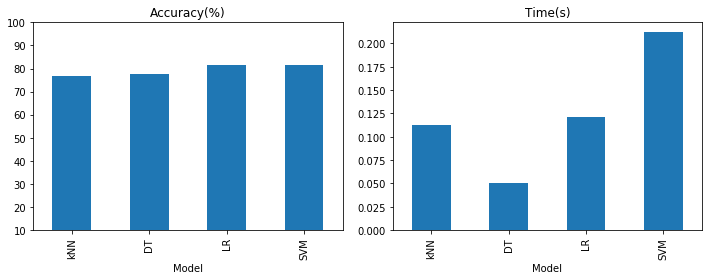

In [17]:
# 结果可视化

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
results_df.plot(y=['Accuracy (%)'], kind='bar', ylim=[10, 100], ax=ax1, title='Accuracy(%)', legend=False)

ax2 = plt.subplot(1, 2, 2)
results_df.plot(y=['Time (s)'], kind='bar', ax=ax2, title='Time(s)', legend=False)
plt.tight_layout()
plt.show()